## Statistical Bill Topic Prediction: an exploration

This notebook runs through our current topic-keyword YAML contents, a set of hand-labeled bills, and establishes a cosine similarity threshold for bills to be automatically labeled without exact keyword matching.

In [1]:
import pandas as pd
from utils import general
# Load data from Google Sheets
source = "https://docs.google.com/spreadsheets/d/1lMXUbSBtRPzzDspoGEklhEXuR2lz3LD8_zRW0FeXCGQ/edit?gid=0#gid=0"
source = source.replace("edit?", "export?format=csv&")
gold = pd.read_csv(source)

# Select only desired columns
cols = gold.columns.tolist()
cols = [c for i, c in enumerate(cols) if i in [0, 2, 3]]
gold = gold.loc[:, cols]
gold = gold.rename(
    columns = {
        'BILL #': 'bill_number',
        'TITLE': 'bill_name',
        'CATEGORY': 'bill_topic'
    }
)
gold.bill_topic = gold.bill_topic.str.replace("Collusion/Price Fixing", "Collusion, Price Fixing")
gold.loc[gold.bill_topic.isna(), 'bill_topic'] = ["Other"]
gold.bill_topic = gold.bill_topic.apply(lambda x: [x])
gold.bill_topic = gold.bill_topic.apply(lambda x: x + ["AI"] if x != ["Other"] else x) # Every bill on the sheet is AI bill

In [2]:
# Load live data for bill excerpts
from db.query import get_data

bills = get_data()

# Merge on bill number and drop columns to get relevant data points
df = pd.merge(gold, bills, on="bill_number", how="left")
df = df.drop(
    [
        'last_updated_on', 
        'event_text', 
        'bill_history', 
        'leginfo_link', 
        'status', 
        'leg_session', 
        'date_introduced', 
        'author', 
        'coauthors',
        'bill_event',
        'chamber',
        'openstates_bill_id'
    ],
    axis=1
    )

2025-07-17 13:47:50.212 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-17 13:47:50.213 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:50.340 
  command:

    streamlit run /Users/jessicawang/.pyenv/versions/3.10.0/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-17 13:47:50.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:50.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:50.341 No runtime found, using MemoryCacheStorageManager


Connected to the PostgreSQL database.


2025-07-17 13:47:50.845 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:50.850 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:52.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 13:47:52.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Database connection closed.


In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, classification_report, confusion_matrix
from nltk.corpus import stopwords
import re

In [4]:
# Define a function to remove stopwords from text

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize
    return ' '.join([w for w in words if w not in stop_words])

In [5]:
# A pretrained model finetuned on the US Code
legal_model = SentenceTransformer("ArchitRastogi/BGE-Small-LegalEmbeddings-USCode")
# A pretrained model finetuned on 1B tokens from the internet
mini_model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Create topic embeddings
legal_embeddings = {}
mini_embeddings = {}
for topic, data in general.topic_config.items():
    # Take the centroid of the topic itself and its keywords
    contents = data["keywords"] + [topic]
    legal_embeddings[topic] = np.mean(legal_model.encode(contents), axis=0)
    mini_embeddings[topic] = np.mean(mini_model.encode(contents), axis=0)

In [7]:
# Use a weighted combination of bill title and abstract to embed the text for cosine similarity

def get_weighted_embedding(model, row, title_weight=0.7):
    title = str(row["bill_name_y"]) # Original bill name, make sure to cast as a string
    abstract = str(row["bill_text"]) # Bill text, recast as a string 
    title_embed = model.encode(preprocess_text(title))
    abstract_embed = model.encode(preprocess_text(abstract))
    return (title_weight * title_embed) + ((1 - title_weight) * abstract_embed)

In [8]:
# Given a pre-computed embedding and label embeddings, add any label if similarity exceeds the threshold
def predict_topics(text_embedding, label_embeddings, threshold=0.3):
    predictions = {}
    for label, embedding in label_embeddings.items():
        similarity = cosine_similarity([text_embedding], [embedding])[0][0]
        predictions[label] = similarity > threshold
    predictions["Other"] = (not any(predictions.values()))
    return predictions

In [9]:
from collections import defaultdict
# Initialize storage
results = []
best_config = {
    'model': None,
    'weight': None,
    'threshold': None,
    'macro_f1': -1,
    'hamming_loss': 1
}

# Single threshold search space
threshold_range = np.linspace(0.1, 0.5, 10)  # Test 10 values between 0.1 and 0.5

# Map from model names to actual objects and topic embeddings
model_topics = {
    "mini": (mini_model, mini_embeddings),
    "legal": (legal_model, legal_embeddings)
}

In [10]:
for m in model_topics:
    curr_model, curr_embeddings = model_topics[m]
    
    for w in range(11):
        weight = w * 0.1
        
        # Generate weighted embeddings (once per weight)
        embed_col = f"{m}_embedding_{w}"
        df[embed_col] = df.apply(
            lambda x: get_weighted_embedding(curr_model, x, title_weight=weight),
            axis=1
        )

        for threshold in threshold_range:
            # Predict with current global threshold
            df['temp_pred'] = df[embed_col].apply(
                lambda x: [
                    t for t, predicted in predict_topics(
                        x, 
                        label_embeddings=curr_embeddings,
                        threshold=threshold  
                    ).items() if predicted
                ]
            )

            # Evaluate
            mlb = MultiLabelBinarizer(classes=sorted(curr_embeddings.keys()) + ["Other"])
            y_true = mlb.fit_transform(df["bill_topic"])
            y_pred = mlb.transform(df['temp_pred'])

            # Filter y_true, y_pred for only classes that are actually used in the data
            active_labels = np.where((y_true.sum(axis=0) > 0) | (y_pred.sum(axis=0) > 0))[0]
            y_true_active = y_true[:, active_labels]
            y_pred_active = y_pred[:, active_labels]

            # Calculate precision, recall, F1
            report = classification_report(
                y_true_active, y_pred_active,
                output_dict=True,
                zero_division=0
            )

            # Calculate Hamming loss as an overall measure across incorrect labels
            h_loss = hamming_loss(y_true_active, y_pred_active)
            macro_f1 = report['macro avg']['f1-score']
            
            # Track all results for analysis
            results.append({
                'model': m,
                'weight': weight,
                'threshold': threshold,
                'macro_f1': macro_f1,
                'hamming_loss': h_loss
            })
            
            # Update best config
            if (macro_f1 > best_config['macro_f1']) or \
               (macro_f1 == best_config['macro_f1'] and h_loss < best_config['hamming_loss']):
                best_config.update({
                    'model': m,
                    'weight': weight,
                    'threshold': threshold,
                    'macro_f1': macro_f1,
                    'hamming_loss': h_loss,
                    'report': report
            })

            # Remove temporary prediction column
            df = df.drop(['temp_pred'], axis=1)
                
# Print best configuration
print(f"\n{'='*50}\nOPTIMAL CONFIGURATION\n{'='*50}")
print(f"Model: {best_config['model']}")
print(f"Title Weight: {best_config['weight']:.1f}")
print(f"Global Threshold: {best_config['threshold']:.3f}")
print(f"Macro-F1: {best_config['macro_f1']:.3f}")
print(f"Hamming Loss: {best_config['hamming_loss']:.3f}\n")

# Show top 5 configurations
print("Top Configurations:")
top_results = sorted(results, key=lambda x: (-x['macro_f1'], x['hamming_loss']))[:5]
for r in top_results:
    print(f"Model: {r['model']}, Weight: {r['weight']:.1f}, Threshold: {r['threshold']:.2f} | "
          f"Macro-F1: {r['macro_f1']:.3f}, Hamming Loss: {r['hamming_loss']:.3f}")


OPTIMAL CONFIGURATION
Model: mini
Title Weight: 0.7
Global Threshold: 0.278
Macro-F1: 0.402
Hamming Loss: 0.145

Top Configurations:
Model: mini, Weight: 0.7, Threshold: 0.28 | Macro-F1: 0.402, Hamming Loss: 0.145
Model: mini, Weight: 0.5, Threshold: 0.28 | Macro-F1: 0.394, Hamming Loss: 0.152
Model: mini, Weight: 0.6, Threshold: 0.28 | Macro-F1: 0.385, Hamming Loss: 0.152
Model: mini, Weight: 0.8, Threshold: 0.28 | Macro-F1: 0.384, Hamming Loss: 0.141
Model: mini, Weight: 0.4, Threshold: 0.23 | Macro-F1: 0.379, Hamming Loss: 0.191


In [12]:
import plotly.express as px
# import pandas as pd

# Convert results to DataFrame for Plotly
results_df = pd.DataFrame(results)

# Filter for best model+weight combo (or pick one manually)
best_combo_df = results_df[
    (results_df['model'] == best_config['model']) & 
    (results_df['weight'] == best_config['weight'])
]

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

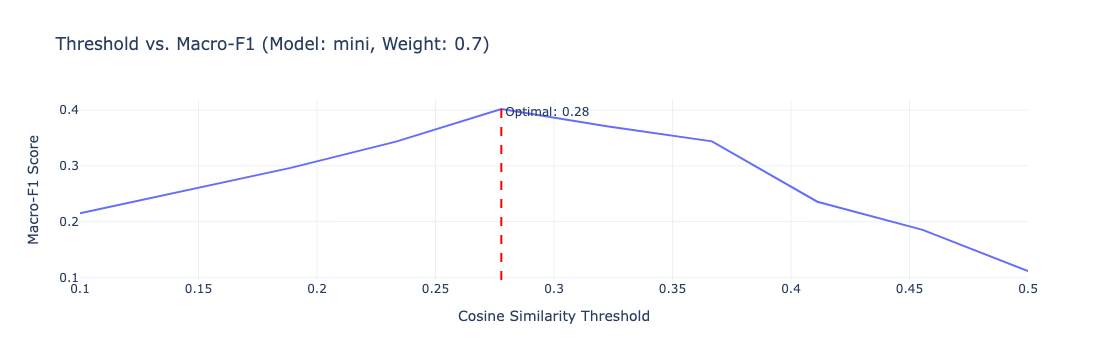

In [26]:
# Create line plot for F1 score and cosine threshold
fig = px.line(
    best_combo_df,
    x='threshold',
    y='macro_f1',
    title=f"Threshold vs. Macro-F1 (Model: {best_config['model']}, Weight: {best_config['weight']:.1f})",
    labels={'threshold': 'Cosine Similarity Threshold', 'macro_f1': 'Macro-F1 Score'},
    template='plotly_white'
)

# Add vertical line for optimal threshold
fig.add_vline(
    x=best_config['threshold'],
    line_dash="dash",
    line_color="red",
    annotation_text=f"Optimal: {best_config['threshold']:.2f}",
    annotation_position="top right"
)

fig.show()

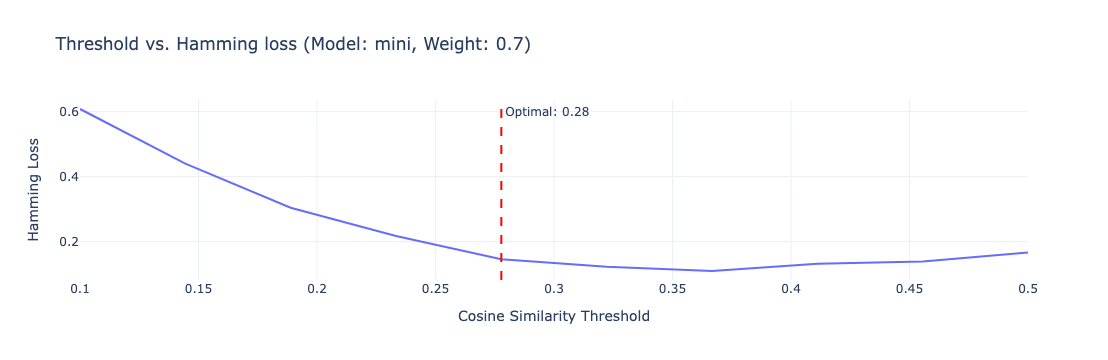

In [15]:
# Create line plot for Hamming loss and cosine
fig = px.line(
    best_combo_df,
    x='threshold',
    y='hamming_loss',
    title=f"Threshold vs. Hamming loss (Model: {best_config['model']}, Weight: {best_config['weight']:.1f})",
    labels={'threshold': 'Cosine Similarity Threshold', 'hamming_loss': 'Hamming Loss'},
    template='plotly_white'
)

# Add vertical line for optimal threshold
fig.add_vline(
    x=best_config['threshold'],
    line_dash="dash",
    line_color="red",
    annotation_text=f"Optimal: {best_config['threshold']:.2f}",
    annotation_position="top right"
)

fig.show()

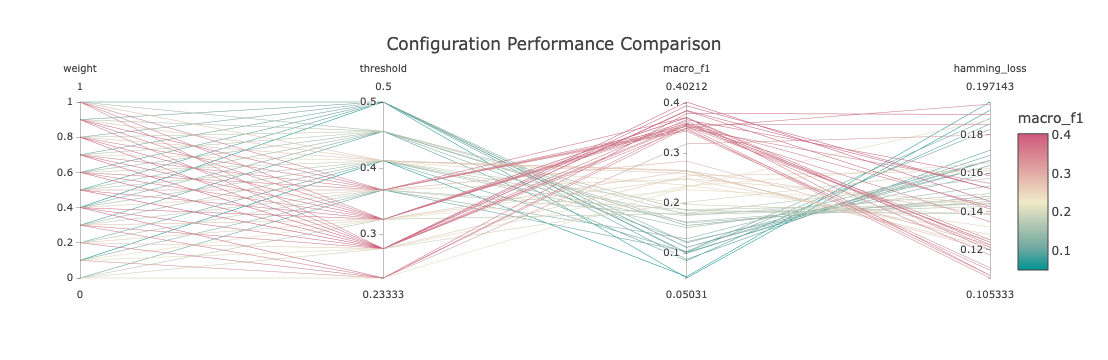

In [30]:
# Parallel coordinates for multi-dimensional analysis
fig = px.parallel_coordinates(
    results_df.loc[results_df.hamming_loss < 0.2],
    color='macro_f1',
    dimensions=['model', 'weight', 'threshold', 'macro_f1', 'hamming_loss'],
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="Configuration Performance Comparison"
)

fig.show()